## Preliminary Classification

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

#! pip install tensorflow
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# import norm
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display


import os
from os import listdir
from os.path import isfile, join
import pickle
#importing module
import sys
sys.path.insert(0, '../data')
from datahandler_multilabel import create_dataset


# to fix some warnings
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 999999999999 # Fix DecompressionBombWarning

## Preprocessing

Normalizing, setting aside a validation split and putting the data in the right format

In [2]:
with open('../data/filenames.pkl', 'rb') as infile:
    filenames = pickle.load(infile)
    
with open('../data/labels.pkl', 'rb') as infile2:
    labels = pickle.load(infile2)
    
df = pd.concat([pd.Series(filenames, name='filenames'), pd.Series(labels, name='labels')], axis=1)
df = shuffle(df, random_state=42)
print(df.shape, df.columns)

(24999, 2) Index(['filenames', 'labels'], dtype='object')


> Run the following cell only in case the dataset has been downloaded after January 2020

In [6]:
mypath = os.path.join('..','..','data_tate')
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] 

filenames1 = []
labels1 = []
for i,img_targ in enumerate(filenames):
    img_targ0 = img_targ.split('\\')[-1]
    if img_targ0 in onlyfiles:
        filenames1.append(str(img_targ))
        labels1.append(labels[i]) 
        
df = pd.concat([pd.Series(filenames1, name='filenames'), pd.Series(labels1, name='labels')], axis=1)
df = shuffle(df)
print(df.shape, df.columns)

(24999, 2) Index(['filenames', 'labels'], dtype='object')


In [3]:
#train test split
train_x = list(df['filenames'][:18000])
train_y = list(df['labels'][:18000])
val_x = list(df['filenames'][18000:21000])
val_y = list(df['labels'][18000:21000])
test_x = list(df['filenames'][21000:])
test_y = list(df['labels'][21000:])
print(len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y))

18000 18000 3000 3000 3999 3999


In [4]:
train_generator = create_dataset(train_x, train_y)
val_generator = create_dataset(val_x, val_y)
test_generator = create_dataset(test_x, test_y)

In [5]:
image_count = len(filenames)
image_count

24999

In [6]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 128 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time

In [7]:
train_generator

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 16)), types: (tf.float32, tf.float64)>

## Classification 

### Using VGG

In [8]:
feature_extractor_layer = {}
# VGG
feature_extractor_layer['VGG'] = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

### Using ResNet

In [11]:
feature_extractor_layer['ResNet'] = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

### Using InceptionV3

In [12]:
feature_extractor_layer['InceptionV3'] = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

Choose desired pretrained changing value of **pretrained**.

In [18]:
pretrained = 'VGG'
feature_extractor_layer[pretrained].trainable = False
feature_extractor_layer[pretrained].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
model = tf.keras.Sequential([
    feature_extractor_layer[pretrained],
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
    tf.keras.layers.Dense(16, activation='sigmoid', name='output')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              25691136  
_________________________________________________________________
output (Dense)               (None, 16)                16400     
Total params: 40,422,224
Trainable params: 25,707,536
Non-trainable params: 14,714,688
_________________________________________________________________


In [61]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

def mean_per_class_accuracy(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    per_class_acc = []
    per_class_acc.append(tf.cast(tf.math.count_nonzero(y_pred[i] * y[i], axis=0), tf.float32))
    mean_acc = tf.reduce_mean(per_class_acc)
    return mean_acc

def precision(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    pres = tp / (tp + fp + 1e-16)
    precision = tf.reduce_mean(pres)
    return precision

def recall(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    rec = tp / (tp + fn + 1e-16)
    recall = tf.reduce_mean(rec)
    return recall

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["binary_accuracy",
                       "categorical_accuracy",
                       #mean_per_class_accuracy,
                       precision,
                       recall,
                       macro_f1
                      ])

Tensor("metrics_30/precision/Mean:0", shape=(), dtype=float32)
Tensor("metrics_30/recall/Mean:0", shape=(), dtype=float32)
Tensor("metrics_30/macro_f1/Mean:0", shape=(), dtype=float32)


In [63]:
csv_logger = tf.keras.callbacks.CSVLogger('training_flat_multilabel_'+str(pretrained)+'.csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    'training_flat_multilabel'+str(pretrained)+'.h5', save_best_only=True,
            )

> If you wish to continue training an already partially trained model, run the following line: 

In [17]:
model = tf.keras.models.load_model('training_flat_multilabel'+str(pretrained)+'.h5', compile=False)

In [ ]:
model.fit(
        train_generator,
        epochs=30,
        validation_data = val_generator,
        callbacks = [csv_logger, checkpoint],
        #use_multiprocessing=True,
)

Epoch 1/30
Tensor("metrics/precision/Mean:0", shape=(), dtype=float32)
Tensor("metrics/recall/Mean:0", shape=(), dtype=float32)
Tensor("metrics/macro_f1/Mean:0", shape=(), dtype=float32)
Tensor("metrics/precision/Mean:0", shape=(), dtype=float32)
Tensor("metrics/recall/Mean:0", shape=(), dtype=float32)
Tensor("metrics/macro_f1/Mean:0", shape=(), dtype=float32)
     13/Unknown - 253s 19s/step - loss: 1.2613 - binary_accuracy: 0.7515 - categorical_accuracy: 0.1525 - precision: 0.1819 - recall: 0.2357 - macro_f1: 0.1690

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
test_generator.reset()
pred = model.predict_generator(test_generator, verbose=1)
model.evaluate(test_generator, verbose=2)
print(pred.shape)

In [ ]:
predicted_class_indices = np.where(pred > 0.5, 1, 0)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [57]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

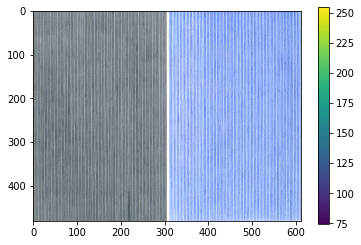

predicted as: Abstract Expressionism 
actual class: Color Field Painting


In [62]:
results = pd.read_csv("results.csv")
img  = Image.open(str(results.Filename[3]))
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()
print('predicted as:', results.Predictions[3],
     '\nactual class:', results.Filename[3].split('/')[0])

For the following days: 
- experiment with data augmentation
- try out other regularization techniques
- try improving the addition of the pre-trained model
- deepen the current model

https://medium.com/towards-artificial-intelligence/understanding-multi-label-classification-model-and-accuracy-metrics-1b2a8e2648ca